# Experimentation with PyTorch

A big part of working with neural networks is experimentation (trying different hyperparemeters, models, feature sets, etc). In this notebook, we walk through the process of experimenting with PyTorch in an organized manner.

### Contents
1. Setting Up the Experimentation Infrastructure
2. Experimenting with Learning Rate and Batch Size
3. Decreasing Running Time with Multi-Process Data Loading
4. Using GPU for Faster Computation
5. Normalizing Data
5. Batch Normalization
6. To Max Pool, or not to to Max Pool?
7. Conclusion and Further Considerations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
import time

In [2]:
# Matplotlib color settings that perfectly match VS code dark theme (not required)
plt.style.use('dark_background')
plt.rcParams.update({
    "figure.facecolor":  (31/255, 31/255, 31/255, 1),
    "axes.facecolor":    (31/255, 31/255, 31/255, 1),
    "savefig.facecolor": (31/255, 31/255, 31/255, 1),
})

## Setting Up the Experimentation Infrastructure

### Dataset(s) and Network(s)

All the datasets and networks that we want to try must be predefined. The datasets must be of type `torch.utils.data.Dataset`. The networks must be defined as functions that return a fresh PyTorch network (with randomly generated parameters).

In [3]:
# The dataset(s) that we want to try
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

In [4]:
# The network(s) that we want to try
def conv_net():
    '''Function that returns a fresh network (with random weights)'''
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1)  ,
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

### Parameters and Dictionaries

The sets of parameters that we want to try must be saved in a dictionary as shown below. Note that the `networks` dictionary and the `train_set` dictionary are there to allow us to easily refer to the networks and datasets without including them directly in the main `params` dictionary.

In [5]:
networks = {
    'conv_net': conv_net,
}

train_sets = {
    'train_set': train_set,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [1000],
    'shuffle': [False],
    'num_workers': [1],
    'device': ['cuda'],
    'train_set': ['train_set'],
    'network': ['conv_net'],
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 2


### Main Function

Finally, we can run all possible combinations of parameters (for a specified number of epochs). While doing this, we keep track of the key information in an organized and python friendly format. The following is an example where we keep track of the loss, accuracy, epoch time, and run time for the parameter combinations defined above in the `params` dictionary.

In [6]:
def run_parameter_combinations(params, networks, train_sets, num_epochs=5):
    """
    Runs all parameter combinations and returns the results as a list of tuples representing each run.
    """
    run_results = [] # All the results are saved in this list (of tuples)

    for i, parameter_values in enumerate(product(*params.values())): # Iterates over all possible parameter combinations

        run_params = dict(zip(params.keys(), parameter_values)) # A dictionary of parameters for the current run
        print(run_params, end='')

        # Initialize the device, network, data-loader, and optimizer (for the current run)
        device = torch.device(run_params['device'])
        network = networks[run_params['network']]().to(device)
        loader = DataLoader(
            train_sets[run_params['train_set']], 
            batch_size = run_params['batch_size'], 
            shuffle = run_params['shuffle'],
            num_workers = run_params['num_workers']
        )
        optimizer = optim.Adam(
            network.parameters(), 
            lr = run_params['learning_rate']
        )

        # Loop over each epoch
        run_data = []
        run_start_time = time.time()
        for epoch in range(num_epochs):

            # Loop over each batch
            total_loss = 0
            total_correct = 0
            epoch_start_time = time.time()
            
            for batch in loader:

                images, labels = batch[0].to(device), batch[1].to(device)

                preds = network(images)
                loss = F.cross_entropy(preds, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * len(labels)
                total_correct += sum(preds.argmax(dim=1)==labels).item()

            # Save the results of an epoch
            epoch_data = {
                'Epoch': epoch + 1,
                'Loss': total_loss,
                'Accuracy': total_correct/len(train_sets[run_params['train_set']]),
                'Epoch Duration': time.time() - epoch_start_time,
                'Run Duration': time.time() - run_start_time,
            }
            run_data.append(epoch_data) # Compile results for all epochs in the run

        print(f' \t {i+1}/{total_runs}')
        run_results.append((run_params, run_data)) # Save the entire run
    
    print('Done!')
    return(run_results)

In [7]:
example_run_results = run_parameter_combinations(params, networks, train_sets)

{'learning_rate': 0.01, 'batch_size': 1000, 'shuffle': False, 'num_workers': 1, 'device': 'cuda', 'train_set': 'train_set', 'network': 'conv_net'} 	 1/2
{'learning_rate': 0.001, 'batch_size': 1000, 'shuffle': False, 'num_workers': 1, 'device': 'cuda', 'train_set': 'train_set', 'network': 'conv_net'} 	 2/2
Done!


### Structure of Run Results

Vocabulary: An **epoch** is one pass through all the training data. A **run** is one full training loop (multiple epochs) with the same parameters.

1. `run_results` is a list containing multiple tuples (each of which contains information about a single run).
2. Each tuple contains two elements - `run_params` and `run_data`.
3. `run_params` is a dictionary containing all the parameters of that run e.g learning-rate, batch-size, etc.
4. `run_data` is a list containing multiple `epoch_data` dictionaries.
5. Each `epoch_data` dictionary contains contains key information related to that epoch e.g epoch number, loss, accuracy, epoch duration, etc.

In [8]:
example_run_results

[({'learning_rate': 0.01,
   'batch_size': 1000,
   'shuffle': False,
   'num_workers': 1,
   'device': 'cuda',
   'train_set': 'train_set',
   'network': 'conv_net'},
  [{'Epoch': 1,
    'Loss': 59480.94445466995,
    'Accuracy': 0.62145,
    'Epoch Duration': 17.144728660583496,
    'Run Duration': 17.144728660583496},
   {'Epoch': 2,
    'Loss': 31258.725970983505,
    'Accuracy': 0.8026166666666666,
    'Epoch Duration': 9.029992818832397,
    'Run Duration': 26.174721479415894},
   {'Epoch': 3,
    'Loss': 26308.06016921997,
    'Accuracy': 0.8383833333333334,
    'Epoch Duration': 8.847907543182373,
    'Run Duration': 35.02262902259827},
   {'Epoch': 4,
    'Loss': 23225.90908408165,
    'Accuracy': 0.8563833333333334,
    'Epoch Duration': 8.658540725708008,
    'Run Duration': 43.681169748306274},
   {'Epoch': 5,
    'Loss': 21331.867814064026,
    'Accuracy': 0.8675833333333334,
    'Epoch Duration': 8.683430910110474,
    'Run Duration': 52.36460065841675}]),
 ({'learning_ra

### Plotting Results

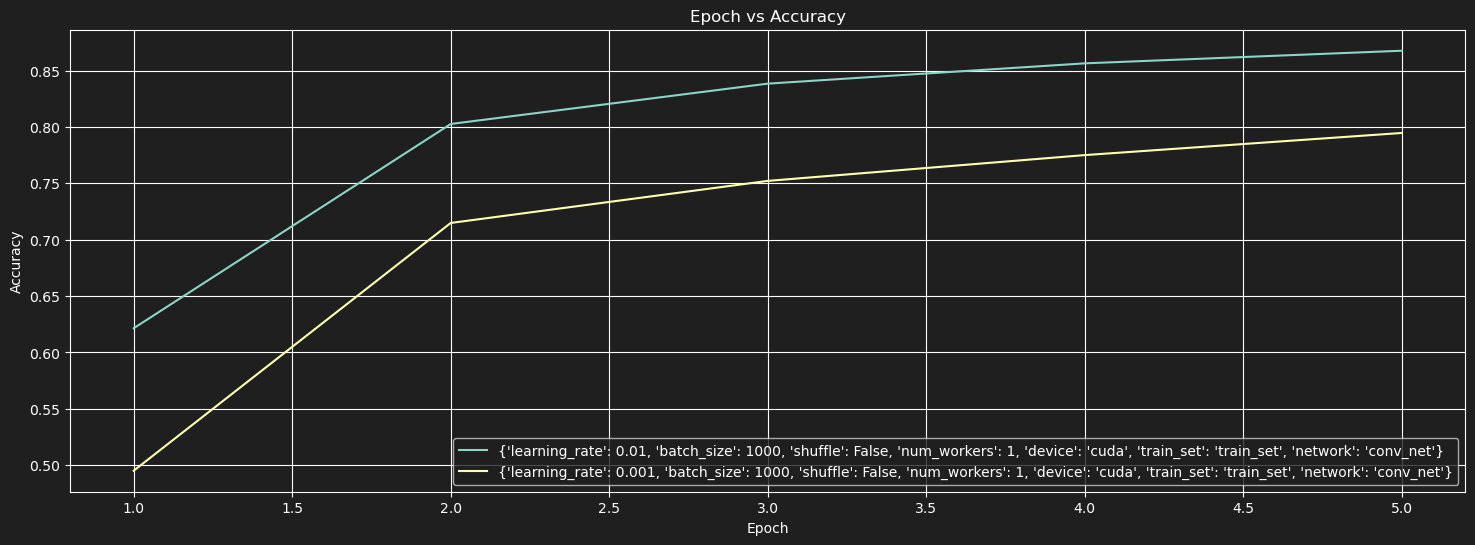

In [9]:
# Epoch vs Accuracy
plt.figure(figsize=(18,6))
plt.title('Epoch vs Accuracy')
for run_params, run_data in example_run_results:
    epoch = []
    accuracy = []
    for data in run_data:
        epoch.append(data['Epoch'])
        accuracy.append(data['Accuracy'])
    plt.plot(epoch, accuracy, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

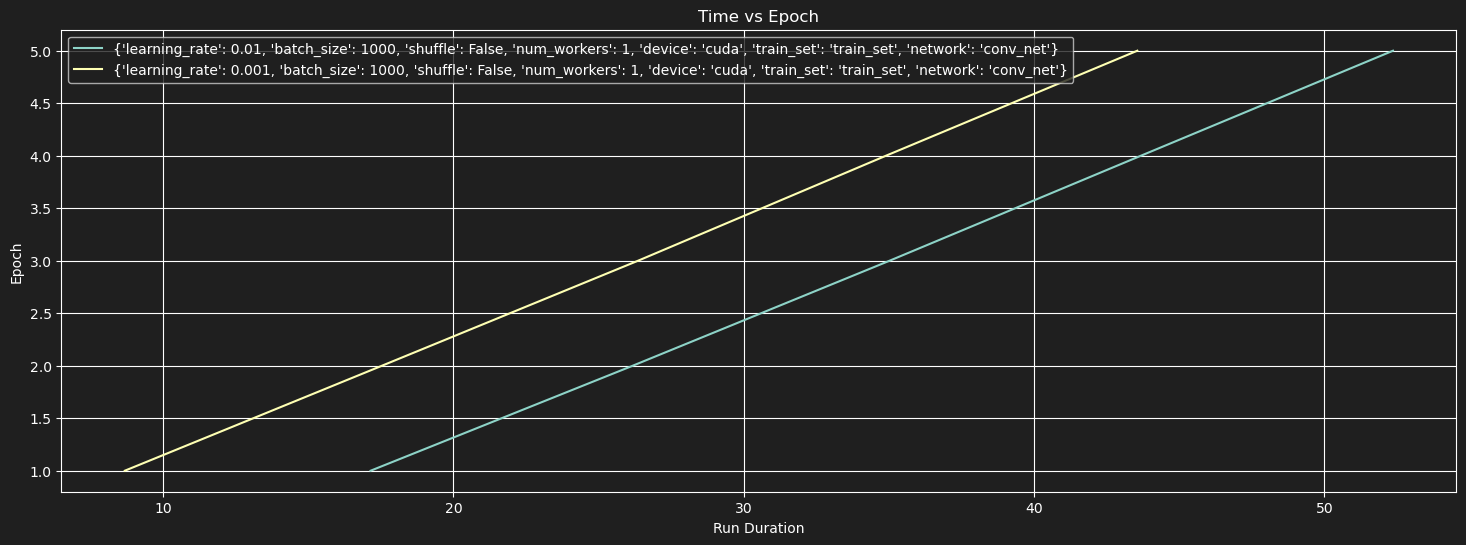

In [10]:
# Time vs Epoch
plt.figure(figsize=(18,6))
plt.title('Time vs Epoch')
for run_params, run_data in example_run_results:
    run_duration = []
    epoch = []
    for data in run_data:
        run_duration.append(data['Run Duration'])
        epoch.append(data['Epoch'])
    plt.plot(run_duration, epoch, label=run_params)
plt.xlabel('Run Duration')
plt.ylabel('Epoch')
plt.legend()
plt.grid()
plt.show()

## Experimenting with Learning Rate and Batch Size

First things first, we must find a good learning rate and batch size.

In [11]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

In [12]:
def conv_net():
    '''Function that returns a fresh network (with random weights)'''
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1)  ,
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [13]:
networks = {
    'conv_net': conv_net,
}

train_sets = {
    'train_set': train_set,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [100, 500, 1000, 5000],
    'shuffle': [False, True],
    'num_workers': [1],
    'device': ['cpu'],
    'train_set': ['train_set'],
    'network': ['conv_net']
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 32


In [14]:
lr_run_results = run_parameter_combinations(params, networks, train_sets)

{'learning_rate': 0.01, 'batch_size': 100, 'shuffle': False, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 1/32
{'learning_rate': 0.01, 'batch_size': 100, 'shuffle': True, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 2/32
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 3/32
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': True, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 4/32
{'learning_rate': 0.01, 'batch_size': 1000, 'shuffle': False, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 5/32
{'learning_rate': 0.01, 'batch_size': 1000, 'shuffle': True, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 6/32
{'learning_rate': 0.01, 'batch_size': 5000, 'shuffle': False, 'num_workers': 1, 'device':

In [15]:
final_accuracies = []
run_parameters = []
losses = []
for run_params, run_data in lr_run_results:
    final_accuracy = run_data[-1]['Accuracy']
    final_accuracies.append(final_accuracy)
    run_parameters.append(run_params)
    losses.append(run_data[-1]['Loss'])
sorted(zip(final_accuracies, losses, run_parameters), reverse=True)[:5] # Sort according to accuracy and pick best 5

[(0.8831833333333333,
  19185.78466773033,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 1,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (0.8825166666666666,
  19109.64130014181,
  {'learning_rate': 0.01,
   'batch_size': 100,
   'shuffle': True,
   'num_workers': 1,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (0.8787666666666667,
  19401.17037296295,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': True,
   'num_workers': 1,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (0.8685666666666667,
  21487.32364177704,
  {'learning_rate': 0.01,
   'batch_size': 1000,
   'shuffle': False,
   'num_workers': 1,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (0.8678833333333333,
  21286.95972710848,
  {'learning_rate': 0.01,
   'batch_size': 100,
   'shuffle': False,
   'num_workers': 1,
   'device': 'cpu',
   'trai

It seems like the best parameters are `batch_size = 500` and `learning_rate = 0.01`. Shuffle does not seem to make a big difference.

## Decreasing Running Time with Multi-Process Data Loading

Within a Python process, the Global Interpreter Lock (GIL) prevents true fully parallelizing Python code across threads. To avoid blocking computation code with data loading, PyTorch provides an easy switch to perform multi-process data loading by simply setting the argument num_workers to a positive integer.

In [16]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

In [17]:
def conv_net():
    '''Function that returns a fresh network (with random weights)'''
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1)  ,
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [18]:
networks = {
    'conv_net': conv_net,
}

train_sets = {
    'train_set': train_set,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01],
    'batch_size': [500],
    'shuffle': [False],
    'num_workers': [1, 2, 4, 8],
    'device': ['cpu'],
    'train_set': ['train_set'],
    'network': ['conv_net']
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 4


In [19]:
num_workers_run_results = run_parameter_combinations(params, networks, train_sets)

{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 1/4
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 2, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 2/4
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 4, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 3/4
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 8, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 4/4
Done!


In [20]:
final_run_durations = []
run_parameters = []
for run_params, run_data in num_workers_run_results:
    final_run_durations.append(run_data[-1]['Run Duration'])
    run_parameters.append(run_params)
sorted(zip(final_run_durations, run_parameters)) # Sort according to run duration

[(38.95161271095276,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 2,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (42.558154582977295,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 4,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (48.581979274749756,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 1,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (54.01650404930115,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 8,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'})]

It seems like `num_workers = 2` is the best option. NOte that this could vary depending on the device you are using.

## Using GPU for Faster Computation

We can take advantage of GPU to run many calculations in paralell to speed up computation.

In [21]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

In [22]:
def conv_net():
    '''Function that returns a fresh network (with random weights)'''
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1)  ,
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [23]:
networks = {
    'conv_net': conv_net,
}

train_sets = {
    'train_set': train_set,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01],
    'batch_size': [500],
    'shuffle': [False],
    'num_workers': [1,2,3],
    'device': ['cpu', 'cuda'],
    'train_set': ['train_set'],
    'network': ['conv_net']
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 6


In [24]:
gpu_run_results = run_parameter_combinations(params, networks, train_sets, num_epochs=15)

{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 1, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 1/6
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 1, 'device': 'cuda', 'train_set': 'train_set', 'network': 'conv_net'} 	 2/6
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 2, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 3/6
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 2, 'device': 'cuda', 'train_set': 'train_set', 'network': 'conv_net'} 	 4/6
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cpu', 'train_set': 'train_set', 'network': 'conv_net'} 	 5/6
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'train_set', 'network': 'conv_net'} 	 6/6
Done!


In [25]:
final_run_durations = []
run_parameters = []
for run_params, run_data in gpu_run_results:
    final_run_durations.append(run_data[-1]['Run Duration'])
    run_parameters.append(run_params)
sorted(zip(final_run_durations, run_parameters)) # Sort according to run duration

[(88.13258218765259,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 3,
   'device': 'cuda',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (94.66341257095337,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 2,
   'device': 'cuda',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (107.02828097343445,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 2,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (124.69363737106323,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 3,
   'device': 'cpu',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (134.94051599502563,
  {'learning_rate': 0.01,
   'batch_size': 500,
   'shuffle': False,
   'num_workers': 1,
   'device': 'cuda',
   'train_set': 'train_set',
   'network': 'conv_net'}),
 (150.81057024002075,
  {'learning_rate': 0.01,
   'ba

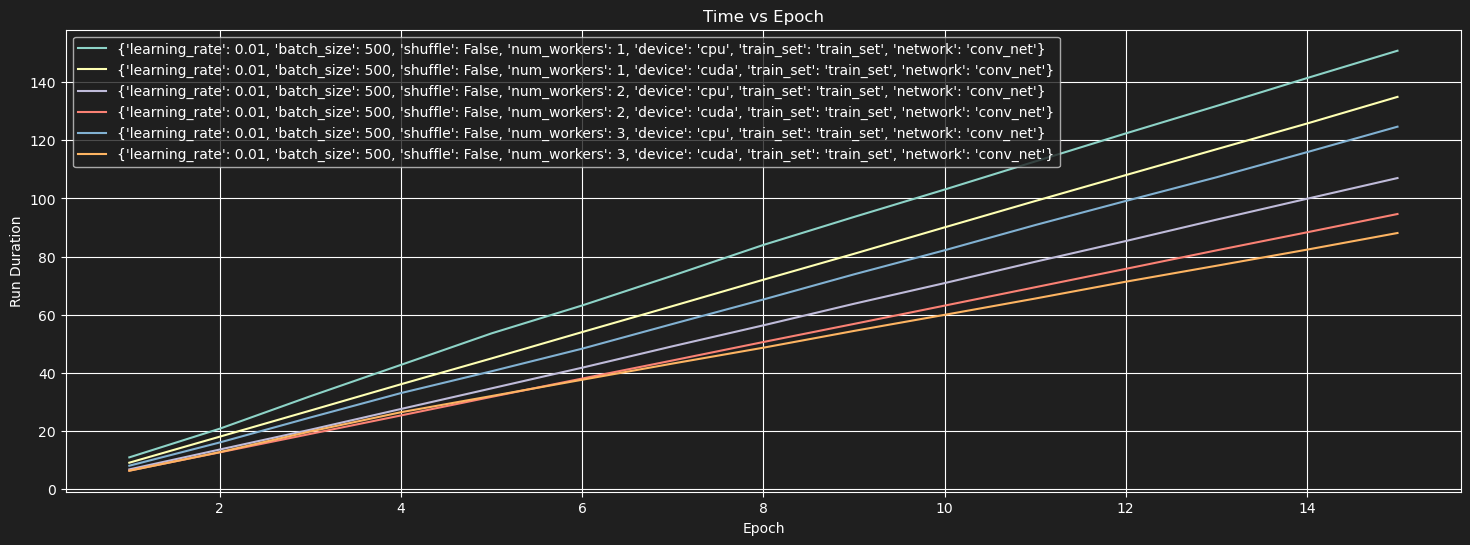

In [26]:
# Time vs Epoch
plt.figure(figsize=(18,6))
plt.title('Time vs Epoch')
for run_params, run_data in gpu_run_results:
    epoch = []
    run_duration = []
    for data in run_data:
        run_duration.append(data['Run Duration'])
        epoch.append(data['Epoch'])
    plt.plot(epoch, run_duration, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Run Duration')
plt.legend()
plt.grid()
plt.show()

It is clear that using GPU is significantly faster than CPU. Interestingly, when using GPU, it becomes faster to use `num_workers = 3` instead of `num_workers = 2`. This is because when we use GPU for computation, the CPU can dedicate more resources to data-loading.

## Normalizing Data

**Normalization:** A general concept that refers to the act of transforming the original values of a dataset to new values. The new values are typically encoded relative to the dataset itself and are scaled in some way.

**Standardization:** A specific type of normalization where we subtract the mean and divide by the standard deviation for all points.

$$z = \frac{x - \mu}{\sigma}$$

In [27]:
# Create a dataloader to load all the data as one batch and compute the mean
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
mean, std = data[0].mean(), data[0].std()
mean, std

(tensor(0.2860), tensor(0.3530))

Note: Sometimes the dataset might be too large to load as one batch so we will need to calculate the mean and std from batches.

In [28]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [29]:
def conv_net():
    '''Function that returns a fresh network (with random weights)'''
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1)  ,
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [30]:
networks = {
    'conv_net': conv_net,
}

train_sets = {
    'not_normal': train_set,
    'normal': train_set_normal,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01],
    'batch_size': [500],
    'shuffle': [False],
    'num_workers': [3],
    'device': ['cuda'],
    'train_set': train_sets.keys(),
    'network': networks.keys()
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 2


In [31]:
normalize_run_results = run_parameter_combinations(params, networks, train_sets, num_epochs=10)

{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'not_normal', 'network': 'conv_net'} 	 1/2
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'normal', 'network': 'conv_net'} 	 2/2
Done!


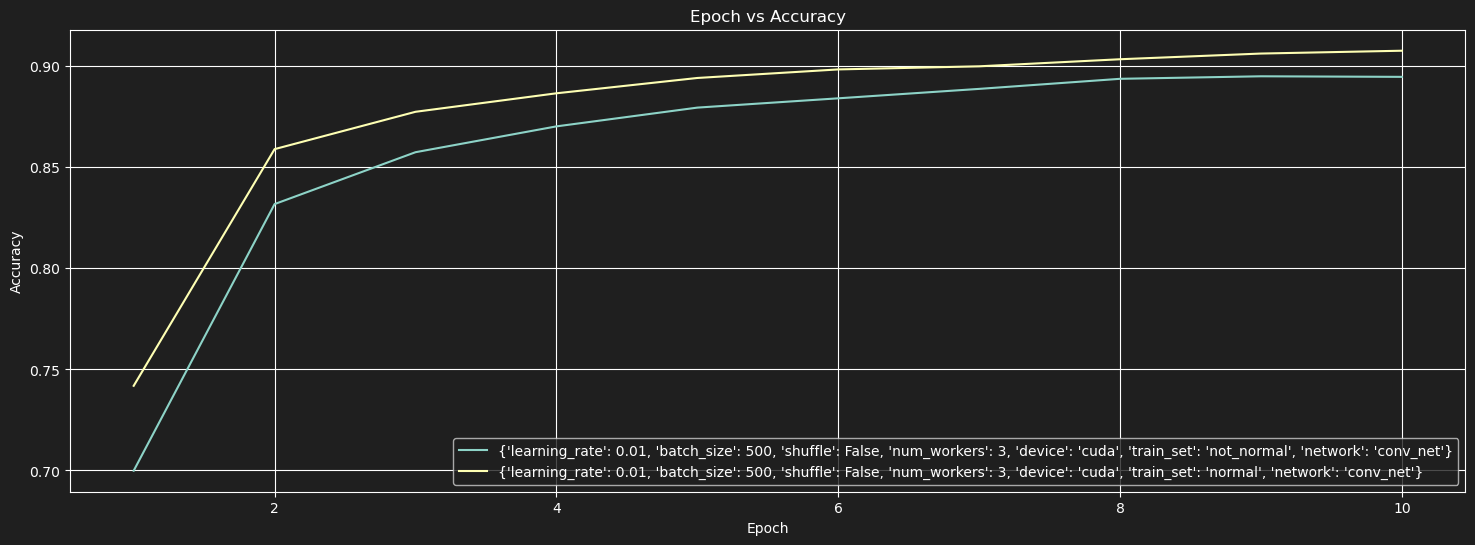

In [32]:
# Epoch vs Accuracy
plt.figure(figsize=(18,6))
plt.title('Epoch vs Accuracy')
for run_params, run_data in normalize_run_results:
    epoch = []
    accuracy = []
    for data in run_data:
        epoch.append(data['Epoch'])
        accuracy.append(data['Accuracy'])
    plt.plot(epoch, accuracy, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

The normalized dataset has a higher accuracy because it converges faster.

## Batch Normalization

When using batch norm, the mean and standard deviation values are calculated with respect to the batch at the time normalization is applied. This is opposed to the entire dataset, like we saw with dataset normalization.

Additionally, there are two learnable parameters that allow the data the data to be scaled and shifted. Note that the scaling given by $\lambda$ corresponds to the multiplication operation, and the sifting given by $\beta$ corresponds to the addition operation.

For more information about how batch normalization works, see the official [research paper](https://arxiv.org/pdf/1502.03167.pdf).

In [33]:
# Create a dataloader to load all the data as one batch and compute the mean
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
mean, std = data[0].mean(), data[0].std()
mean, std

(tensor(0.2860), tensor(0.3530))

In [34]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data', # The location on disk where the data is located.
    train = True, # If the dataset is the training set
    download = True, # If the data should be downloaded
    transform = transforms.Compose([ # A composition of transformations that should be performed on the dataset elements.
        transforms.ToTensor()
    ])
)

train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [35]:
def conv_net():
    '''Function that returns a fresh network (with random weights)'''
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1)  ,
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

def conv_net_with_batch_norm():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(6),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.BatchNorm1d(120),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [36]:
networks = {
    'no_batch_norm': conv_net,
    'batch_norm': conv_net_with_batch_norm
}

train_sets = {
    'not_normal': train_set,
    'normal': train_set_normal,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01],
    'batch_size': [500],
    'shuffle': [False],
    'num_workers': [3],
    'device': ['cuda'],
    'train_set': train_sets.keys(),
    'network': networks.keys()
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 4


In [37]:
batch_norm_run_results = run_parameter_combinations(params, networks, train_sets, num_epochs=10)

{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'not_normal', 'network': 'no_batch_norm'} 	 1/4
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'not_normal', 'network': 'batch_norm'} 	 2/4
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'normal', 'network': 'no_batch_norm'} 	 3/4
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'normal', 'network': 'batch_norm'} 	 4/4
Done!


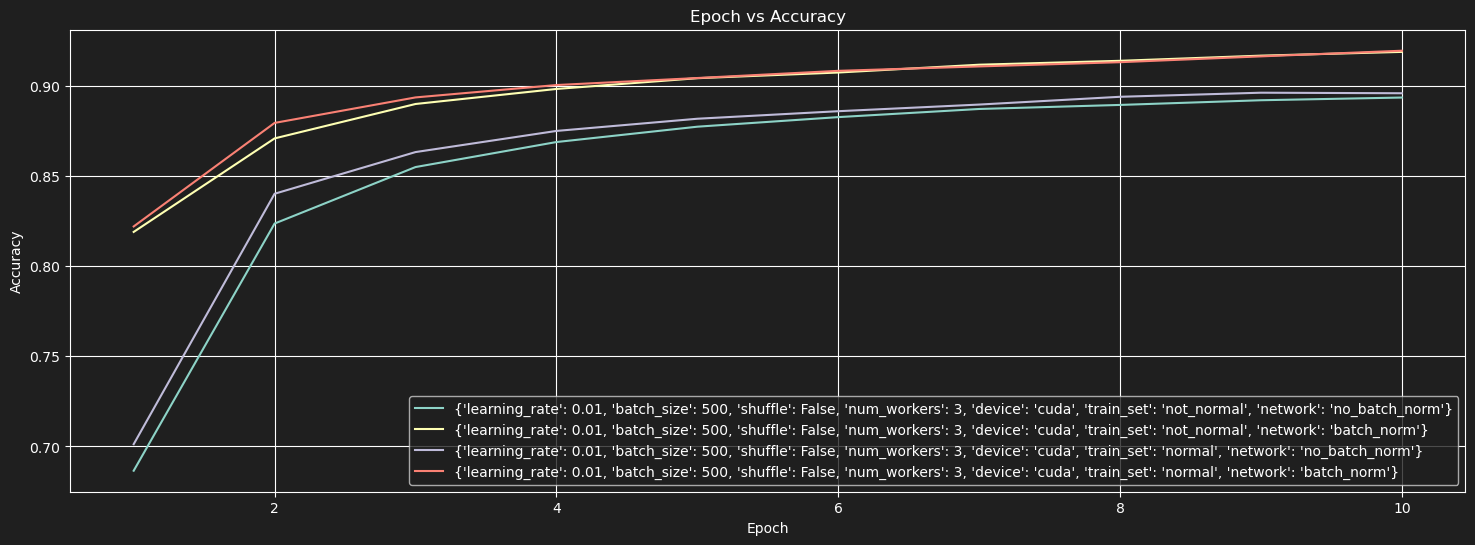

In [38]:
# Epoch vs Accuracy
plt.figure(figsize=(18,6))
plt.title('Epoch vs Accuracy')
for run_params, run_data in batch_norm_run_results:
    epoch = []
    accuracy = []
    for data in run_data:
        epoch.append(data['Epoch'])
        accuracy.append(data['Accuracy'])
    plt.plot(epoch, accuracy, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

It is clear that batch norm greatly improves performance and results in even faster convergance. The best combination is to use a normalized dataset with batch norm.

## To Max Pool, or not to to Max Pool?

To max pool, or not to max pool? So far we have been using max pool in our networks to reduce the input to the next convolutional layer, however in doing so we may be losing out on valuble information that our network could have used to make better predictions. To test this hypothis, we cun run both scenarios and see the results.

In [39]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [40]:
def conv_net_with_max_pool():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(6),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=12*4*4, out_features=120),
        nn.ReLU(),
        nn.BatchNorm1d(120),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

def conv_net_without_max_pool():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.BatchNorm2d(6),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=12*20*20, out_features=120),
        nn.ReLU(),
        nn.BatchNorm1d(120),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [41]:
networks = {
    'max_pool': conv_net_with_max_pool,
    'no_max_pool': conv_net_without_max_pool
}

train_sets = {
    'normal': train_set_normal,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01],
    'batch_size': [500],
    'shuffle': [False],
    'num_workers': [3],
    'device': ['cuda'],
    'train_set': train_sets.keys(),
    'network': networks.keys()
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 2


In [42]:
max_pool_run_results = run_parameter_combinations(params, networks, train_sets, num_epochs=20)

{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'normal', 'network': 'max_pool'} 	 1/2
{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'normal', 'network': 'no_max_pool'} 	 2/2
Done!


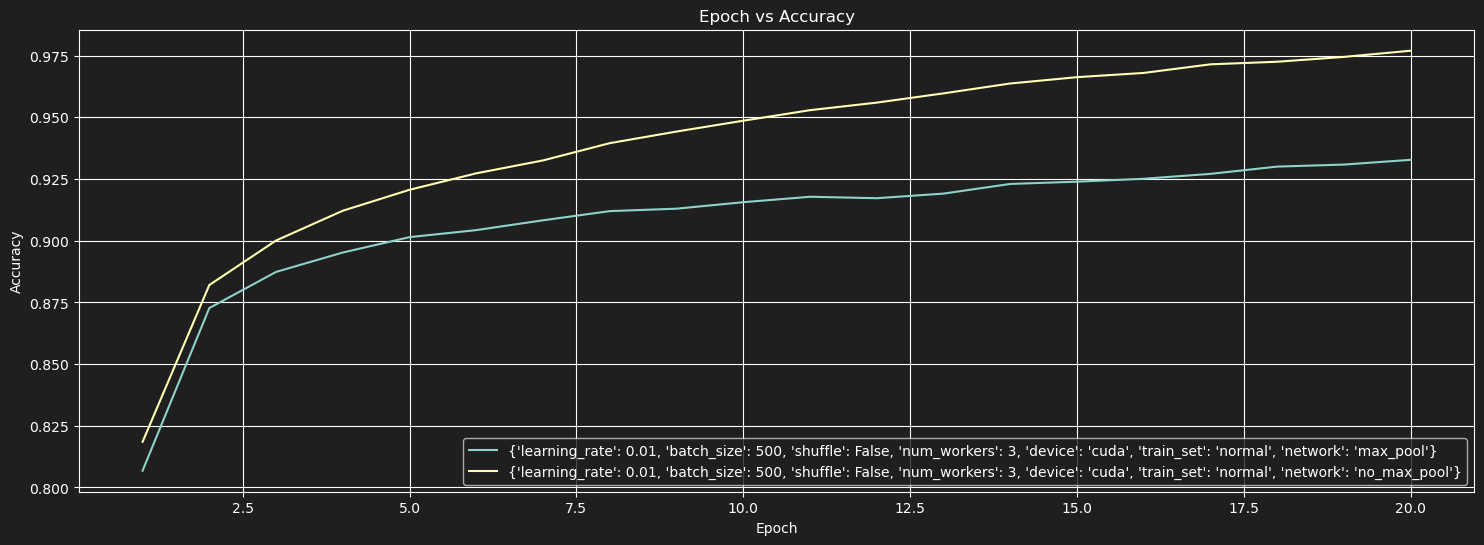

In [43]:
# Epoch vs Accuracy
plt.figure(figsize=(18,6))
plt.title('Epoch vs Accuracy')
for run_params, run_data in max_pool_run_results:
    epoch = []
    accuracy = []
    for data in run_data:
        epoch.append(data['Epoch'])
        accuracy.append(data['Accuracy'])
    plt.plot(epoch, accuracy, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [44]:
print('Accuracy:', max_pool_run_results[1][1][-1]['Accuracy'])

Accuracy: 0.9770166666666666


It is clear that not using max pool hugely improves the performance.

## Conclusion and Further Considerations

Using the optimal parameters that we have found, we can train a network over many more epochs and see how high an accuracy we can achieve.

In [45]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [46]:
def network():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.BatchNorm2d(6),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=12*20*20, out_features=120),
        nn.ReLU(),
        nn.BatchNorm1d(120),
        nn.Linear(in_features=120, out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60, out_features=10),
    )

In [47]:
networks = {
    'best_network': network,
}

train_sets = {
    'normal': train_set_normal,
}

# The set(s) parameters that we want to try
params = {
    'learning_rate': [0.01],
    'batch_size': [500],
    'shuffle': [False],
    'num_workers': [3],
    'device': ['cuda'],
    'train_set': train_sets.keys(),
    'network': networks.keys()
}

total_runs = len(list(product(*params.values())))
print(f'Total Runs: {total_runs}')

Total Runs: 1


In [48]:
best_run_results = run_parameter_combinations(params, networks, train_sets, num_epochs=50)

{'learning_rate': 0.01, 'batch_size': 500, 'shuffle': False, 'num_workers': 3, 'device': 'cuda', 'train_set': 'normal', 'network': 'best_network'} 	 1/1
Done!


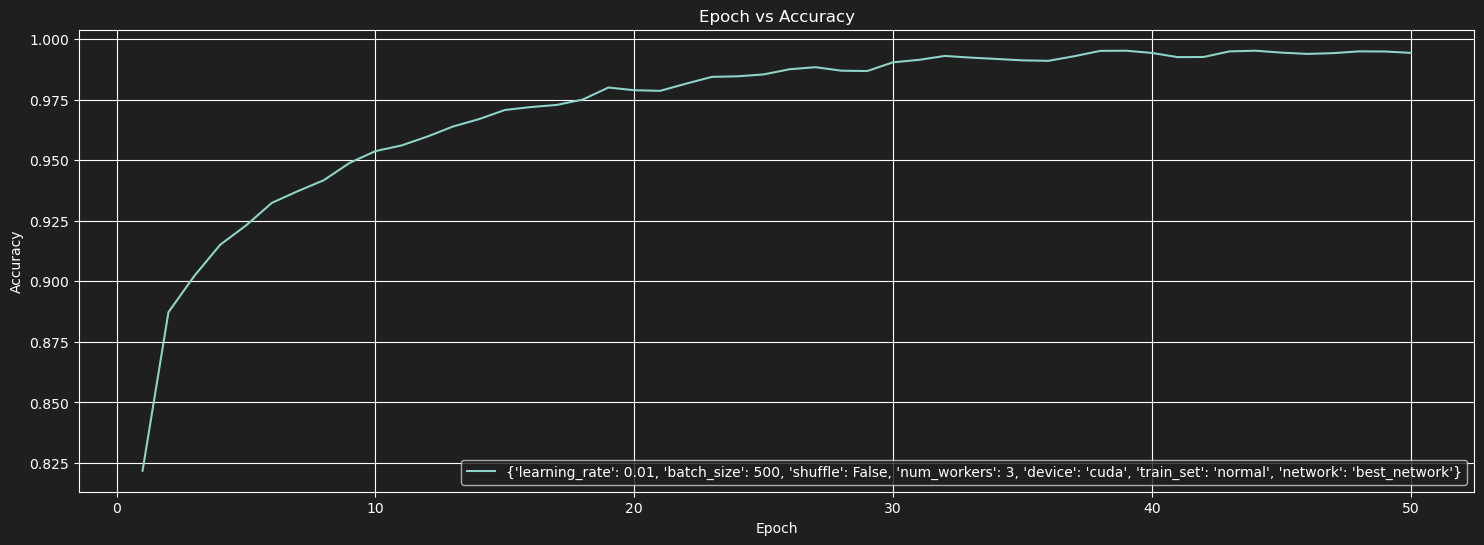

In [49]:
# Epoch vs Accuracy
plt.figure(figsize=(18,6))
plt.title('Epoch vs Accuracy')
for run_params, run_data in best_run_results:
    epoch = []
    accuracy = []
    for data in run_data:
        epoch.append(data['Epoch'])
        accuracy.append(data['Accuracy'])
    plt.plot(epoch, accuracy, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [50]:
print('Accuracy:', best_run_results[0][1][-1]['Accuracy'])

Accuracy: 0.9943666666666666


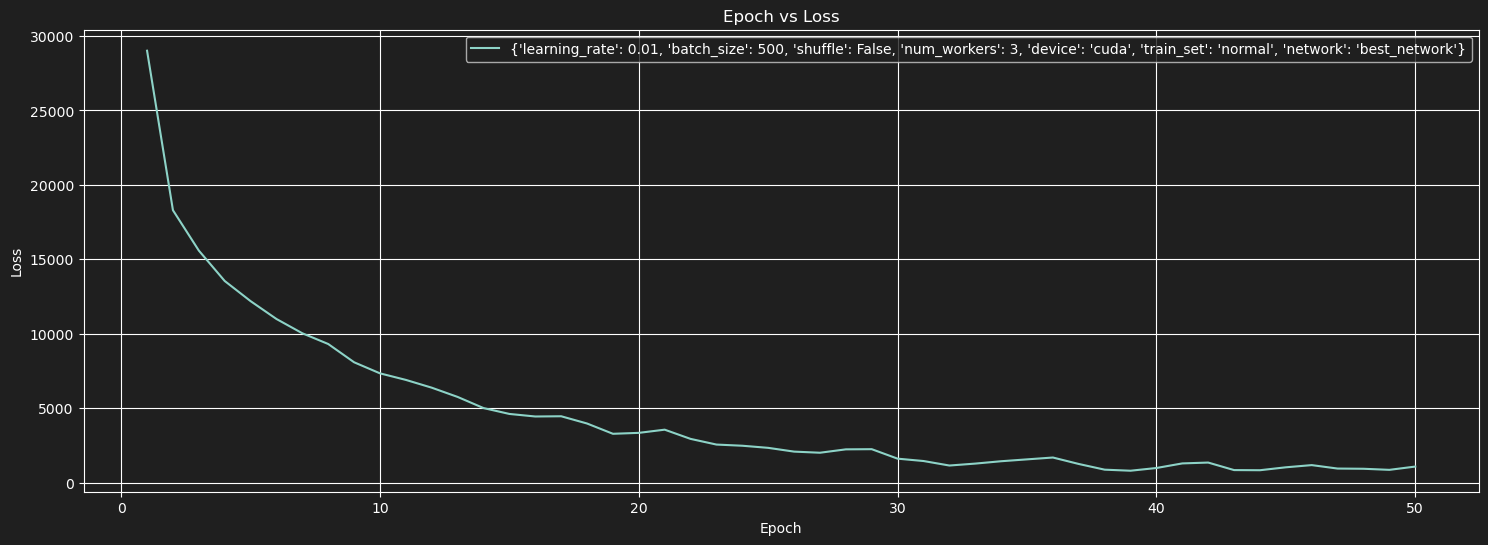

In [51]:
# Epoch vs Accuracy
plt.figure(figsize=(18,6))
plt.title('Epoch vs Loss')
for run_params, run_data in best_run_results:
    epoch = []
    accuracy = []
    for data in run_data:
        epoch.append(data['Epoch'])
        accuracy.append(data['Loss'])
    plt.plot(epoch, accuracy, label=run_params)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

By now, we have experimented with learning rate, batch size, multi-process data loading, GPU computation, normalized training data, batch normalization, and max pooling. From these experiments, we have found a set of parameters that results in an accuracy above 99% after 50 epochs! 

More importantly, we spent the time to develop an infrastructure that allows us to easily run these experiments. This infrastructure can be applied to other projects too and can easily extended to also try different optimizers, loss functions, and network architectures.